In [ ]:
#!pip install numpy pandas statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 10.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

#### 1.2 Simulamos X1 , X2 y Asignación al Tratamiento
En la práctica, las personas pueden apuntarse o ser seleccionadas para el programa de forma tal que la asignación podría estar correlacionada con su educación y/o experiencia. Por ejemplo, podemos asumir que la **probabilidad de recibir tratamiento** $P(D=1)$ es mayor para aquellos que tienen mayor educación o experiencia:

$$
P(D=1|X_1,X_2) = logistic(-4 + 0.2X_1 + 0.15X_2)
$$

o equivalentemente:

$$
P(D=1) = \frac{1}{1+\exp[-(-4 + 0.2X_1 + 0.15X_2)]}
$$

#### 1.3 Generamos el Outcome ($Y$) mediante el siguiente proceso:

$$
Y 
= \beta_0 
+ \tau \, D 
+ \beta_1 \, X_1 
+ \beta_2 \, X_2 
+ \varepsilon
$$

donde $\varepsilon \sim N(0, \sigma^2)$

In [ ]:
#Notar: X1 y X2 son "confounders":
# 1) Son variables previas al tratamiento.
# 2) Afectan simultánemanete la asignación al tratamiento y el resultado
# Esto implica: el tratamiento no es aleatorio respecto a los resultados potenciales; depende de confusores que también afectan Y -> se rompe
# el supuesto de ignorabilidad

## 2. Set up de la Simulación

In [24]:
# Simulación de parámetros:

np.random.seed(123)  # para reproducibilidad

N = 250  # tamaño de la muestra

# Parámetros "verdaderos" (teóricos)
beta0 = 20   # intercepto
tau   = 5    # efecto del tratamiento (treatment effect)
beta1 = 1    # efecto de los años de educación
beta2 = 2    # efecto de los años de experiencia
sigma = 1.5    # desviación std del término de error

#### Nuestros confounders serán:
* X1 (Educación): años de escolaridad, entre 8 y 16
* X2 (Experiencia): años de experiencia, entre 0 y 10

In [25]:
#### Vamos a generar los confounders:
X1 = np.random.uniform(8, 16, size=N).round()    # educación
X2 = np.random.uniform(0, 10, size=N).round()    # experiencia

#### Suponemos que la probabilidad de recibir tratamiento depende de nuestros confounders X1 y X2, y generamos la asignación de tratamiento mediante una función logística:

In [26]:
logit = -4 + 0.2*X1 + 0.15*X2
prob_D = 1 / (1 + np.exp(-logit))
D = np.random.binomial(n=1, p=prob_D, size=N)

#### Generamos Y:

In [27]:
eps = np.random.normal(loc=0, scale=sigma, size=N)
Y = beta0 + tau*D + beta1*X1 + beta2*X2 + eps

In [28]:
#Construimos nuestro DataFrame:
sim_data = pd.DataFrame({
    'Y': Y,
    'D': D,
    'X1': X1,
    'X2': X2
})


print(sim_data.head())

           Y  D    X1   X2
0  37.054072  0  14.0  2.0
1  35.908437  0  10.0  4.0
2  50.369032  1  10.0  7.0
3  38.089645  0  12.0  4.0
4  44.710984  1  14.0  2.0


### 3. Ajustamos un modelos de regresión lineal

#### ¿Qué pasaría si sólo midiéramos el "efecto" del tratamiento?

In [29]:
outcome = sim_data['Y']
predictors = sim_data[['D']]

# Añadimos el intercepto
predictors = sm.add_constant(predictors)

# Ajustamos una regresión mediante MCO
model = sm.OLS(outcome, predictors)
results = model.fit()

# Resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     81.86
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           4.38e-17
Time:                        17:05:55   Log-Likelihood:                -826.83
No. Observations:                 250   AIC:                             1658.
Df Residuals:                     248   BIC:                             1665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6001      0.510     79.545      0.0

#### Comentar sesgo del estimador
Parece que el estimador del efecto del tratamiento (tau) es sesgado debido a la presencia de los confounders X1 y X2. 
El modelo no controla por estas variables, lo que significa que el efecto estimado de D sobre Y puede estar contaminado por la influencia de X1 y X2.

#### Incorporando los confounders

In [30]:
# Definimos outcome (Y) y predictoras (X)
outcome = sim_data['Y']
predictors = sim_data[['D', 'X1', 'X2']]

# Añadimos el intercepto
predictors = sm.add_constant(predictors)

# Ajustamos una regresión mediante MCO
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1989.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          3.95e-172
Time:                        17:06:02   Log-Likelihood:                -458.84
No. Observations:                 250   AIC:                             925.7
Df Residuals:                     246   BIC:                             939.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4319      0.544     35.697      0.0

#### Interpretación del coeficiente asociado a D

In [40]:
# El efecto del tratamiento (tau) se estima como el coeficiente de D en la regresión, que es 4.99 miles de dólares adicionales en el ingreso anual.

* Podemos decir que el efecto del tratamiento (programa de capacitación) es de 4.4k USD sobre el ingreso
* Es decir, en promedio, aquellos que tomaron el programa ganan 4.4k más que los que no lo tomaron una vez que CONTROLAMOS educación y experiencia

## 4. Diagnósticos de Causalidad

### 4.1 Soporte Común

#### Para ello primero calculamos la "Propensity Score":
$$
P(D=1|X_1,X_2)
$$

In [31]:
# Ajustando una regresión logística para el tratamiento 
X_logit = sim_data[["X1", "X2"]]
y_logit = sim_data["D"]

logit_model = LogisticRegression(fit_intercept=True, solver='lbfgs')
logit_model.fit(X_logit, y_logit)

# Calculando probabilidades
prop_score = logit_model.predict_proba(X_logit)[:, 1]

sim_data["propensity_score"] = prop_score


#### Visualizando intersección (overlap)

Graficando la distribución de las probabilidades para aquellos que recibieron tratamiento (D=1) vs aquellos que no (D=0). Idealmente, queremos que las distribuciones tengas superposición.  

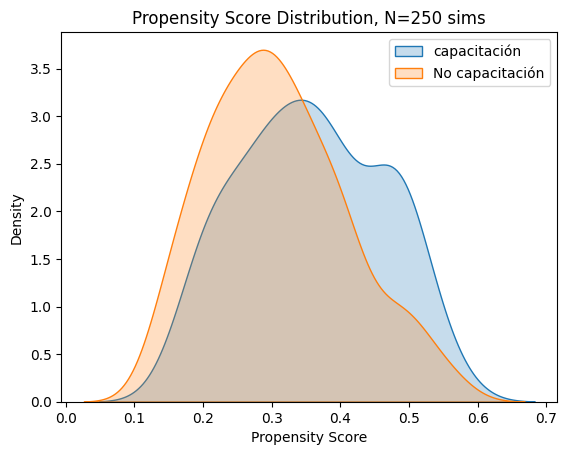

In [ ]:
sns.kdeplot(data=sim_data[sim_data["D"]==1], x="propensity_score", fill=True, label="capacitación")
sns.kdeplot(data=sim_data[sim_data["D"]==0], x="propensity_score", fill=True, label="No capacitación")
plt.title("Propensity Score Distribution, N=250 sims")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
#Comentario: hay "buena" superposición?

### Inverse probability weighting

In [42]:
# IPTW weights:  w = 1 / p(D=1|X) para tratamiento D=1,  w = 1 / [1 - p(D=1|X)] para los no tratados

sim_data["weight"] = np.where(sim_data["D"] == 1,
                              1 / sim_data["propensity_score"],
                              1 / (1 - sim_data["propensity_score"]))

# Media ponderada de X1 en tratados vs no tratados:

treated_weighted_mean_X1   = np.average(sim_data.loc[sim_data["D"]==1, "X1"],
                                        weights=sim_data.loc[sim_data["D"]==1, "weight"])
untreated_weighted_mean_X1 = np.average(sim_data.loc[sim_data["D"]==0, "X1"],
                                        weights=sim_data.loc[sim_data["D"]==0, "weight"])

print("Weighted Mean of X1 for Treated:   ", treated_weighted_mean_X1)
print("Weighted Mean of X1 for Untreated: ", untreated_weighted_mean_X1)

# Media ponderada de X2 en tratados vs no tratados:

treated_weighted_mean_X2   = np.average(sim_data.loc[sim_data["D"]==1, "X2"],
                                        weights=sim_data.loc[sim_data["D"]==1, "weight"])
untreated_weighted_mean_X2 = np.average(sim_data.loc[sim_data["D"]==0, "X2"],
                                        weights=sim_data.loc[sim_data["D"]==0, "weight"])

print("Weighted Mean of X2 for Treated:   ", treated_weighted_mean_X2)
print("Weighted Mean of X2 for Untreated: ", untreated_weighted_mean_X2)

Weighted Mean of X1 for Treated:    12.046912301081655
Weighted Mean of X1 for Untreated:  12.014180809324392
Weighted Mean of X2 for Treated:    4.870511209065573
Weighted Mean of X2 for Untreated:  4.843106961001532


In [44]:
#### con esto podemos comprobar es que los pesos IPTW están funcionando como deberían, ya que las medias ponderadas de los confounders X1 y X2 son similares entre los grupos tratados y no tratados.

In [43]:
sim_data["weight"].sum()

np.float64(499.29958315340747)

### 1. Vamos a *suponer* un proceso generador de los datos de tal forma que podamos explicar cómo abordar la causalidad mediante un modelo de regresión lineal. Tomemos el siguiente ejemplo:
Queremos medir el efecto causal (causal effect) de un programa de capacitación (D) - *tratamiento*- , en el ingreso anual (Y), donde tenemos además dos variables que influyen en el ingreso:
* Educación (medida en años, X1)
* Experiencia laboral (medida en años, X2)

#### 1.1 Parámetros
Definimos los parámetros “verdaderos”  de la siguiente forma:
* Intercepto $\beta_0: 20$  (ingreso anual base en miles de USD)
* Efecto del tratamiento (programa de capacitación) en miles de USD: $\tau = 5$ (el incremento en el ingreso debido al programa de capacitación es de 5k USD, en promedio, manteniendo lo demás constante)
* Efecto de la educación: $\beta_1: 1$ (cada año adicional de escolaridad/educación incrementa el ingreso anual en 1k USD)
* Efecto de la experiencia: $\beta_2: 2$ (cada año adicional de experiencia incrementa el ingreso anual en 2k USD)
* Varianza del error: $\sigma=1.5$

### 4.2 Balance

####  Diferencias de Medias Estandarizadas

$$
\text{SMD} \;=\; \frac{\overline{X}_\mathrm{treated} \;-\; \overline{X}_\mathrm{control}}
{\sqrt{\frac{s^2_\mathrm{treated} + s^2_\mathrm{control}}{2}}}
$$


In [34]:
def smd(x_t, x_c, w_t=None, w_c=None):
    """Standardized mean difference (con o sin pesos)."""
    if w_t is None:
        # medias simples
        mt, mc = np.mean(x_t), np.mean(x_c)
        vt, vc = np.var(x_t, ddof=1), np.var(x_c, ddof=1)
    else:
        # medias ponderadas
        mt = np.average(x_t, weights=w_t)
        mc = np.average(x_c, weights=w_c)
        vt = np.average((x_t - mt) ** 2, weights=w_t)
        vc = np.average((x_c - mc) ** 2, weights=w_c)
    return (mt - mc) / np.sqrt(0.5 * (vt + vc))

treated   = sim_data[sim_data["D"] == 1]
control   = sim_data[sim_data["D"] == 0]

for var in ["X1", "X2"]:
    raw  = smd(treated[var], control[var])
    w    = smd(treated[var], control[var],
               w_t=treated["weight"], w_c=control["weight"])
    print(f"{var}:  SMD sin peso = {raw:.3f}   |   SMD IPTW = {w:.3f}")


X1:  SMD sin peso = 0.262   |   SMD IPTW = 0.015
X2:  SMD sin peso = 0.416   |   SMD IPTW = 0.009


In [45]:
# Obserce que la SMD sin pesos son mayores a 0.1, lo que indica un sesgo en la asignación al tratamiento.

### Recortamos pesos 'extremos'

In [35]:
# Trimming simple: descartar pesos por encima del percentil 99 o por debajo del 1
pct1, pct99 = np.percentile(sim_data["weight"], [1, 99])
mask = (sim_data["weight"] >= pct1) & (sim_data["weight"] <= pct99)
sim_trim = sim_data.loc[mask].copy()


In [ ]:
# comparando tamaños de muestra
print("Original sample size:", sim_data.shape[0])
print(sim_trim.shape)
print(" ")
print(sim_data.shape)

(246, 6)
 
(250, 6)


In [ ]:
# 1. Ojo, ahora es con el DataFrame recortado (sim_trim)
ps_trim = sim_trim["propensity_score"]

# 2. Pesos estabilizados
p_treated = (sim_trim["D"] == 1).mean()          # proporción de tratados tras el recorte
sim_trim["sw"] = np.where(sim_trim["D"] == 1,
                          p_treated / ps_trim,
                          (1 - p_treated) / (1 - ps_trim))

# 3. Regresión ponderada con pesos estabilizados sw:

y  = sim_trim["Y"]
X  = sm.add_constant(sim_trim["D"])
w  = sim_trim["sw"]

wls_sw = sm.WLS(y, X, weights=w).fit(cov_type="HC3") # Belsey, Kuh y Welsh, 1984. Reggression with robust standard errors
print(wls_sw.summary())

# 4. Regresión doblemente robusta (doubly robust):

X_dr = sm.add_constant(sim_trim[["D", "X1", "X2"]])  # const, D, X1, X2
y     = sim_trim["Y"]
w     = sim_trim["sw"]
dr_model = sm.WLS(y, X_dr, weights=w).fit(cov_type="HC3")
print(dr_model.summary())




                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.141
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     39.69
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           1.38e-09
Time:                        17:57:17   Log-Likelihood:                -813.57
No. Observations:                 246   AIC:                             1631.
Df Residuals:                     244   BIC:                             1638.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6624      0.535     77.886      0.0